In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython.display as ipd
from scipy.signal import get_window
from scipy.fftpack import fft

### Load Data

In [3]:
PATH = Path('data/')
TRAIN_PATH = PATH/'audio_train'

In [4]:
train = pd.read_csv(PATH/'train.csv')

In [5]:
idx = 1
row = train.iloc[idx]
print(row)

fname                001ca53d.wav
label                   Saxophone
manually_verified               1
Name: 1, dtype: object


### Display Signal

Sample Rate   44100 Hz
Clip Length   10.32 seconds
Frame Length  46.44 milliseconds


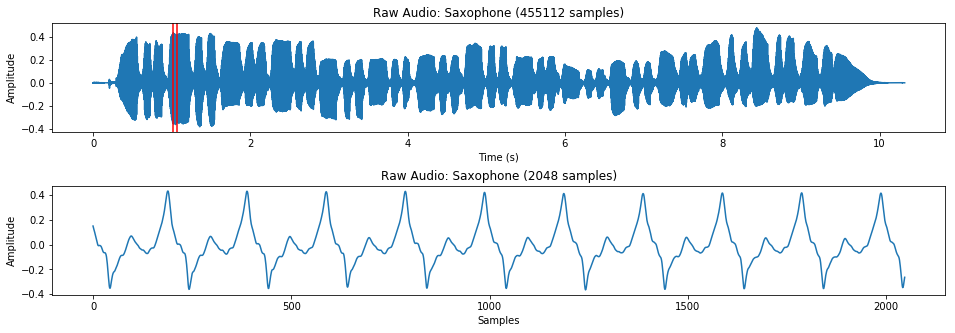

In [6]:
N = 2048   # FFT Frame size
H = 512    # Hop Size (N/4)

fname = TRAIN_PATH/row.fname
clip, sample_rate = librosa.load(fname, sr=None)

timesteps = np.arange(len(clip)) / sample_rate  # in seconds

fig, ax = plt.subplots(2, figsize=(16, 5))
fig.subplots_adjust(hspace=0.5)

ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} ({} samples)'.format(row.label, len(clip)))


start = 45000 # start at a part of the sound thats not silence.. 
x = clip[start:start+N]

# mark location of frame
ax[0].axvline(start/sample_rate, c='r') 
ax[0].axvline((start+N)/sample_rate, c='r')

ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Raw Audio: {} ({} samples)'.format(row.label, len(x)))

print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(clip)/sample_rate))
print('Frame Length  {:3.2f} milliseconds'.format(len(x)/sample_rate*1000))

ipd.Audio(clip, rate=sample_rate)

### Window and Compute FFT (Fast Fourier Transform)

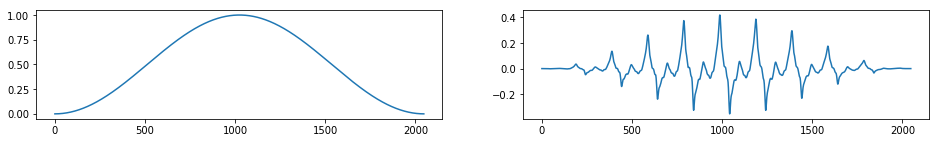

In [7]:
# window_length = N
window = get_window('hann', N)
wx = x * window

fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].plot(window)
ax[1].plot(wx);

In [8]:
# Compute FFT on window
X = fft(x, N)
X.shape, X.dtype

((2048,), dtype('complex64'))

FFT returns the a complex array of size N

X.real.shape: (2048,)
X.imag.shape: (2048,)


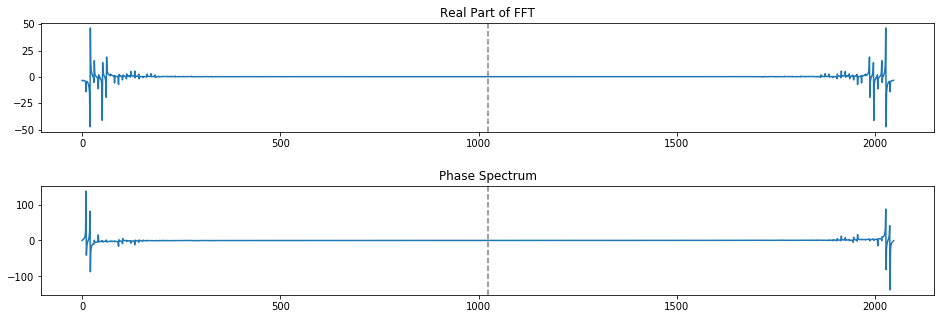

In [9]:
fig, ax = plt.subplots(2, figsize=(16, 5))
fig.subplots_adjust(hspace=0.5)
ax[0].plot(X.real)
ax[0].set_title('Real Part of FFT')
ax[0].axvline(x=1025, c='grey', ls='--')
ax[1].plot(X.imag)
ax[1].axvline(x=1025, c='grey', ls='--')
ax[1].set_title('Phase Spectrum');

print('X.real.shape:', X.real.shape) 
print('X.imag.shape:', X.imag.shape)

The real component of the FFT is mirrored around the center, so everything after sample 1025 is redundant.

The imaginary component is mirrored and also flipped around the center sample.

In practice, we keep the first 1025 samples of each (N/2 + 1)

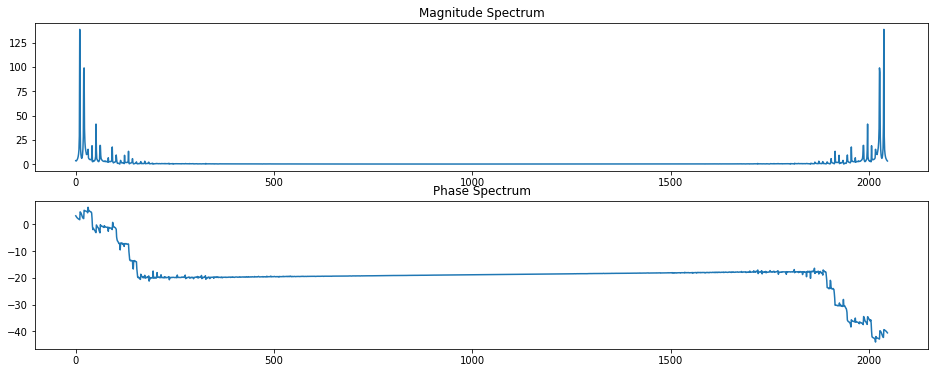

In [10]:
# Calculate the magnitude and phase spectrum
X_mag = abs(X)
X_phase = np.unwrap(np.angle(X))

fig, ax = plt.subplots(2, figsize=(16, 6))
ax[0].plot(X_mag)
ax[0].set_title('Magnitude Spectrum')
ax[1].plot(X_phase)
ax[1].set_title('Phase Spectrum');
# ax[1].yaxis('Radians') # Not completely sure on this one..

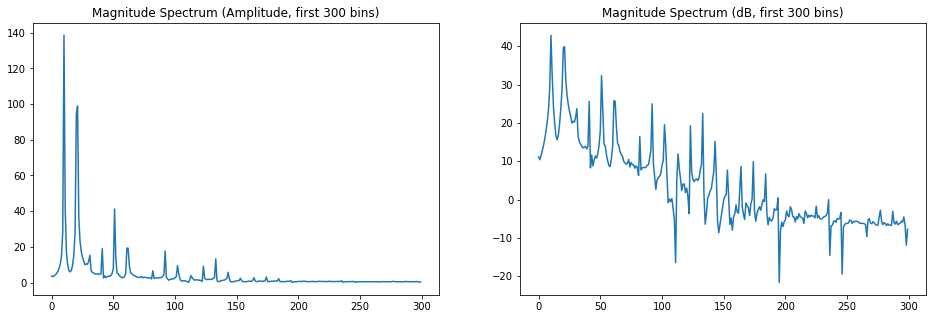

In [11]:
X_mag_dB = 20*np.log10(X_mag)

_, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(X_mag[:300])
ax[0].set_title('Magnitude Spectrum (Amplitude, first 300 bins)')
ax[1].plot(X_mag_dB[:300])
ax[1].set_title('Magnitude Spectrum (dB, first 300 bins)');

Each 'bin' in the FFT corresponds to a range of frequencies, centered around its center frequency.  This is calculated by multiplying the bin index with `sample_rate / N`.

In [12]:
highest_peak_bin_idx = np.argmax(X_mag)
peak_frequency = sample_rate / N * highest_peak_bin_idx
print('Highest bin at index {} corresponds to about {:.2f} Hz'.format(highest_peak_bin_idx, peak_frequency))

Highest bin at index 10 corresponds to about 215.33 Hz


Text(0.5,1,'Magnitude Spectrum (N=512, first 75 bins)')

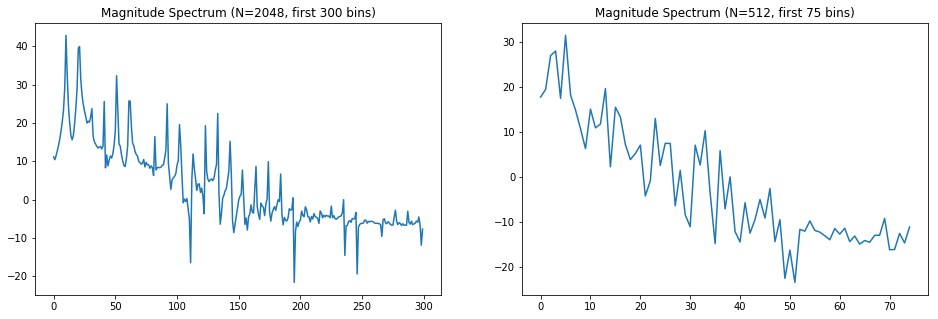

In [13]:
X_512 = fft(x[:512], 512)
X_512_mag_dB = 20*np.log10(abs(X_512))

_, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(X_mag_dB[:300])
ax[0].set_title('Magnitude Spectrum (N=2048, first 300 bins)')
ax[1].plot(X_512_mag_dB[:75])
ax[1].set_title('Magnitude Spectrum (N=512, first 75 bins)')

These two plots cover the same frequency range, but the one with the higher N has a better frequency resolution.  In the first plot, you can clearly see the individual harmonics of the note.

In [14]:
dur_2048 = 2048 / sample_rate * 1000
dur_512  = 512  / sample_rate * 1000
print('2048 sample duration: {:.2f} ms'.format(dur_2048))
print('512  sample duration: {:.2f} ms'.format(dur_512))

2048 sample duration: 46.44 ms
512  sample duration: 11.61 ms


### STFT (Short Time Fourier Transform): Time vs Frequency Resolution Comparison

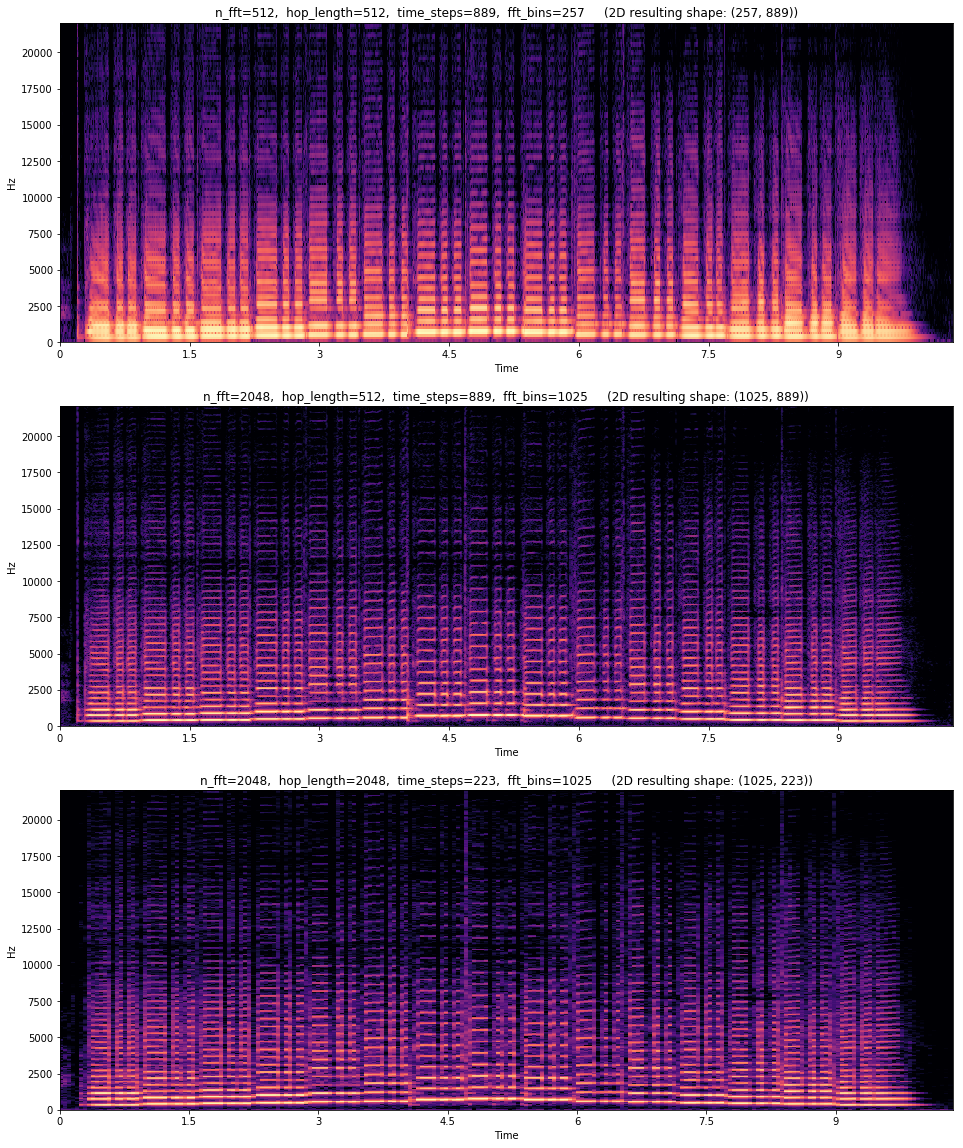

In [15]:
N_H_values = [
    (512, 512),
    (2048, 512),
    (2048, 2048)
]

plt.figure(figsize=(16, 20))
fig.subplots_adjust(hspace=0.5)

bin_pct = 0.5 # only show the bottom half of the spectrum, where most of the interesting stuff is 

for i in range(len(N_H_values)):
    N, H = N_H_values[i]
    
    stft = librosa.core.stft(clip, n_fft=N, hop_length=H)
    num_bins = stft.shape[0]
    mags = np.abs(stft)
    mags_db = librosa.core.amplitude_to_db(mags, ref=np.max)
    
    plt.subplot(len(N_H_values), 1, i+1)
    librosa.display.specshow(mags_db[:int(num_bins*bin_pct),:], 
                             x_axis='time', y_axis='linear', sr=sample_rate, hop_length=H)
    title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}     (2D resulting shape: {})'
    plt.title(title.format(N, H, stft.shape[1], stft.shape[0], stft.shape))


The top plot has no overlap, uses n_fft=512 so it has good time resolution (space between notes) but poor frequency resolution (harmonics are smeared together). 

The bottom plot also has no overlap, uses n_fft=2048 so it has good frequency resolution, but not as good time resolution, and you can't really see space between notes.

The middle plot uses a large FFT window and a small hop size, so it gets the best of both worlds.  However, the output 2D image is also the largest.  

### Log Mel Spectrogram: Time vs Frequency vs # Mels Comparison

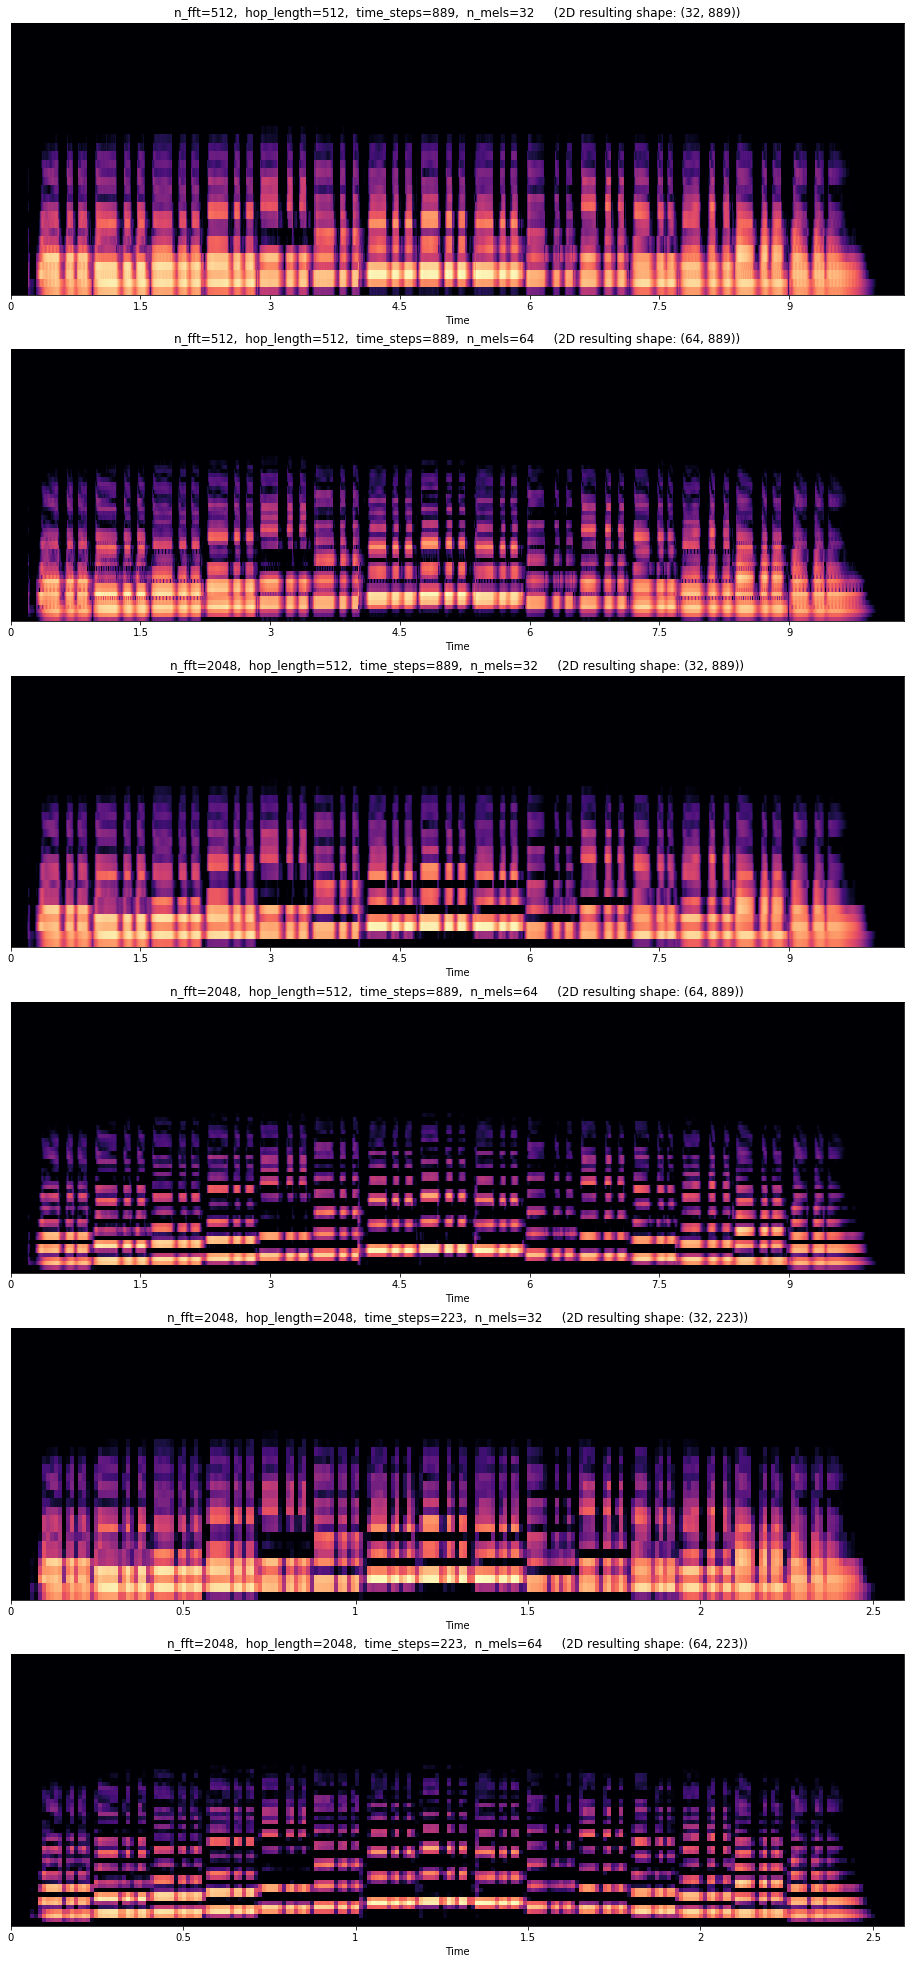

In [17]:
N_H_M_values = [
    (512, 512, 32),
    (512, 512, 64),
    (2048, 512, 32),
    (2048, 512, 64),
    (2048, 2048, 32),
    (2048, 2048, 64),
]

plt.figure(figsize=(16, 35))
fig.subplots_adjust(hspace=0.5)

bin_pct = 1.0 

for i in range(len(N_H_M_values)):
    N, H, M = N_H_M_values[i]
    
    stft = librosa.feature.melspectrogram(clip, n_fft=N, hop_length=H, n_mels=M, sr=sample_rate)
    num_bins = stft.shape[0]
    mags = np.abs(stft)
    mags_db = librosa.core.amplitude_to_db(mags, ref=np.max)
    
    plt.subplot(len(N_H_M_values), 1, i+1)
    librosa.display.specshow(mags_db[:int(num_bins*bin_pct),:], 
                             x_axis='time', y_axis=None, sr=sample_rate) # y_axis='mel' does not seem correct
    title = 'n_fft={},  hop_length={},  time_steps={},  n_mels={}     (2D resulting shape: {})'
    plt.title(title.format(N, H, stft.shape[1], stft.shape[0], stft.shape))
